In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_results(solvers, solver_names):
    """生成累积懊悔随时间变化的图像。输入solvers是一个列表,列表中的每个元素是一种特定的策略。
    而solver_names也是一个列表,存储每个策略的名称"""
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative regrets')
    plt.title('%d-armed bandit' % solvers[0].bandit.K)
    plt.legend()
    plt.show()

In [3]:
class BernoulliBandit:
    """ 伯努利多臂老虎机,输入K表示拉杆个数 """
    def __init__(self, K):
        self.probs = np.random.uniform(size=K)  # 随机生成K个0～1的数,作为拉动每根拉杆的获奖
        # 概率
        self.best_idx = np.argmax(self.probs)  # 获奖概率最大的拉杆
        self.best_prob = self.probs[self.best_idx]  # 最大的获奖概率
        self.K = K

    def step(self, k):
        # 当玩家选择了k号拉杆后,根据拉动该老虎机的k号拉杆获得奖励的概率返回1（获奖）或0（未
        # 获奖）
        if np.random.rand() < self.probs[k]:
            return 1
        else:
            return 0

In [4]:
class Solver:
    """ 多臂老虎机算法基本框架 """
    def __init__(self, bandit):
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K)  # 每根拉杆的尝试次数
        self.regret = 0.  # 当前步的累积懊悔
        self.actions = []  # 维护一个列表,记录每一步的动作
        self.regrets = []  # 维护一个列表,记录每一步的累积懊悔

    def update_regret(self, k):
        # 计算累积懊悔并保存,k为本次动作选择的拉杆的编号
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)

    def run_one_step(self):
        # 返回当前动作选择哪一根拉杆,由每个具体的策略实现
        raise NotImplementedError

    def run(self, num_steps):
        # 运行一定次数,num_steps为总运行次数
        for _ in range(num_steps):
            k = self.run_one_step()
            self.counts[k] += 1
            self.actions.append(k)
            self.update_regret(k)

In [5]:
class EpsilonGreedy(Solver):
    """采用了ε-贪婪算法"""
    def __init__(self, bandit, epsilon = 0.01, init_prob = 1.0):
        super(EpsilonGreedy, self).__init__(bandit)
        self.epsilon = epsilon
        self.init_prob = init_prob
        self.estimated_prob = np.array([init_prob] * self.bandit.K)

    def run_one_step(self):
        if np.random.random() < self.epsilon:
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.argmax(self.estimated_prob)
        reward = self.bandit.step(k)
        self.estimated_prob[k] += 1. / (self.counts[k] + 1) * (reward - self.estimated_prob[k])
        return k

In [6]:
class DecayingEpsilonGreedy(Solver):
    """ epsilon值随时间衰减的epsilon-贪婪算法,继承Solver类 """
    def __init__(self, bandit, init_prob=1.0):
        super(DecayingEpsilonGreedy, self).__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.total_count = 0

    def run_one_step(self):
        self.total_count += 1
        if np.random.random() < 1 / self.total_count:  # epsilon值随时间衰减
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.argmax(self.estimates)

        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])

        return k

In [7]:
np.random.seed(1)  # 设定随机种子,使实验具有可重复性
K = 10
num_steps = 5000
epsilons = [1e-4, 0.01, 0.1, 0.25, 0.5, 0.8]

bandit_10_arm = BernoulliBandit(K)
print("随机生成了一个%d臂伯努利老虎机" % K)
print("获奖概率最大的拉杆为%d号,其获奖概率为%.4f" %
      (bandit_10_arm.best_idx, bandit_10_arm.best_prob))

随机生成了一个10臂伯努利老虎机
获奖概率最大的拉杆为1号,其获奖概率为0.7203


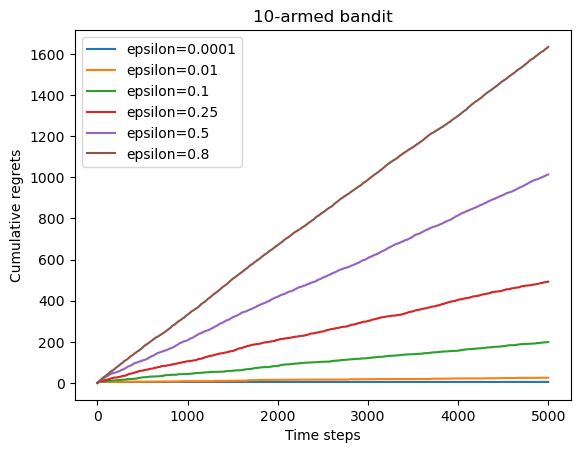

In [8]:
np.random.seed(1)
epsilon_greedy_solvers = [EpsilonGreedy(bandit_10_arm, epsilon=epsilon,init_prob=1.0) for epsilon in epsilons]
for solver in epsilon_greedy_solvers:
    np.random.seed(1)
    solver.run(num_steps)
# print('epsilon-贪婪算法的累积懊悔为：', epsilon_greedy_solver.regret)
plot_results(epsilon_greedy_solvers, ["epsilon="+str(epsilon) for epsilon in epsilons])

epsilon值衰减的贪婪算法的累积懊悔为： 10.114334931260183


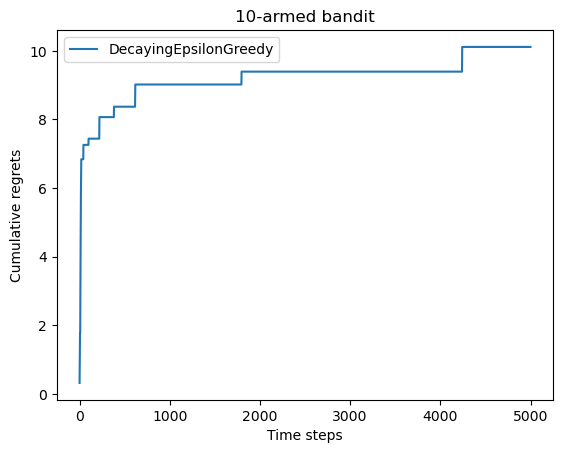

In [9]:
np.random.seed(1)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)
decaying_epsilon_greedy_solver.run(5000)
print('epsilon值衰减的贪婪算法的累积懊悔为：', decaying_epsilon_greedy_solver.regret)
plot_results([decaying_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])

In [11]:
class UCB(Solver):
    def __init__(self, bandit, coef = 1, init_prob = 1.0):
        super(UCB, self).__init__(bandit)
        self.total_count = 0
        self.coef = coef
        self.estimated_prob = np.array([init_prob] * self.bandit.K)

    def run_one_step(self):
        self.total_count += 1
        ucb = self.estimated_prob + self.coef * np.sqrt(np.log(self.total_count)/(2*(self.counts+1)))
        k = np.argmax(ucb)
        reward = self.bandit.step(k)
        self.estimated_prob[k] += 1. / (self.counts[k] + 1) * (reward - self.estimated_prob[k])
        return k

UCB算法的累积懊悔为： 70.45281214197854


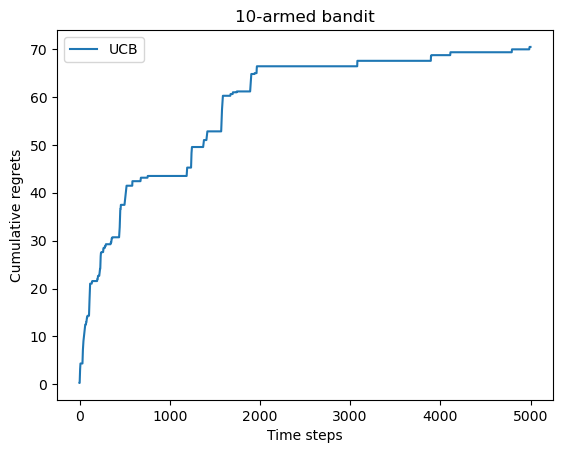

In [13]:
np.random.seed(1)
coef = 1
num_steps = 5000
ucb_solver = UCB(bandit_10_arm, coef = coef)
ucb_solver.run(num_steps)
print('UCB算法的累积懊悔为：', ucb_solver.regret)
plot_results([ucb_solver], ["UCB"])

In [20]:
class ThompsonSampling(Solver):
    """ 汤普森采样算法,继承Solver类 """
    def __init__(self, bandit):
        super(ThompsonSampling, self).__init__(bandit)
        self._a = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为1的次数
        self._b = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为0的次数

    def run_one_step(self):
        samples = np.random.beta(self._a, self._b)  # 按照Beta分布采样一组奖励样本
        print(samples.size)
        k = np.argmax(samples)  # 选出采样奖励最大的拉杆
        r = self.bandit.step(k)

        self._a[k] += r  # 更新Beta分布的第一个参数
        self._b[k] += (1 - r)  # 更新Beta分布的第二个参数
        return k

[3.78164892e-04 6.13798727e-01 3.50231061e-01 4.24085262e-01
 3.92453864e-02 4.27568748e-01 4.14746642e-01 6.85293315e-01
 1.89327153e-01 2.37994556e-02]
[0.30643143 0.50502143 0.87036454 0.76233941 0.35073268 0.0850426
 0.19935024 0.87241572 0.89237247 0.49674501]
[0.22984312 0.6326096  0.00462945 0.38262124 0.01673748 0.55687796
 0.08034465 0.85131419 0.43132242 0.10311358]
[0.10677389 0.32277699 0.02276058 0.69487804 0.73144586 0.32260807
 0.14853829 0.44619132 0.79193147 0.84094563]
[0.15209492 0.60397275 0.71640651 0.15199803 0.74976053 0.91878783
 0.23224325 0.79966738 0.05618528 0.44521511]
[0.18501754 0.48326444 0.95917045 0.0785449  0.71710637 0.3682075
 0.974728   0.1893227  0.91904791 0.99956254]
[0.20856063 0.32734197 0.48189678 0.55849207 0.31757417 0.71036539
 0.83399942 0.82597305 0.25638459 0.60533985]
[0.2817856  0.45633858 0.7252122  0.16504249 0.75759196 0.81902011
 0.77192441 0.06440982 0.89637143 0.04295576]
[0.11589976 0.67737285 0.79538095 0.9313513  0.1770303  0

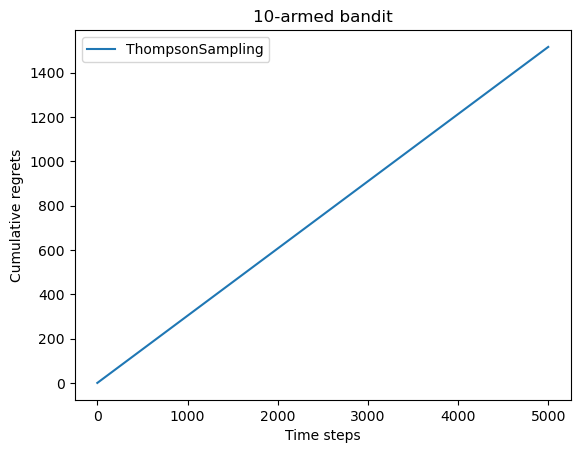

In [21]:
np.random.seed(1)
thompson_sampling_solver = ThompsonSampling(bandit_10_arm)
thompson_sampling_solver.run(5000)
print('汤普森采样算法的累积懊悔为：', thompson_sampling_solver.regret)
plot_results([thompson_sampling_solver], ["ThompsonSampling"])